# Download IP102 dataset from Kaggle

In [1]:
# install kaggle library
!pip install -q kaggle

# add Kaggle private api key
!mkdir /root/.kaggle
!echo '{"username":"jgupta07","key":"31b5d3936a3059099e6164fdc8b90c82"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# download dataset
!kaggle datasets download -d jgupta07/ip102-dataset

# unzip to working directory
!mkdir /content/ip102
!unzip -q ip102-dataset.zip -d /content/ip102/
!ls

100% 2.93G/2.94G [00:51<00:00, 21.3MB/s]
100% 2.94G/2.94G [00:51<00:00, 61.0MB/s]
ip102  ip102-dataset.zip  sample_data


# Import packages

In [0]:
# customary imports
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# for AlexNet
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# for TensorBoard
import datetime, os

# Keep only top *n* classes

In [0]:
import os

# function to get number of examples per class, per dataset
def getClassCounts(dataset_path):
  counts = {}
  root, dirs, _ = next(os.walk(dataset_path))
  for subdir in dirs:
    _, _, files_subdir = next(os.walk(os.path.join(root, subdir)))
    counts[subdir] = len(files_subdir)
  return counts

In [0]:
# call function to get class counts for each dataset
train_dict = getClassCounts('./ip102/train/')
test_dict = getClassCounts('./ip102/test/')
val_dict = getClassCounts('./ip102/val/')

In [0]:
# sort the counts
classes = list(np.arange(0,102))

train_counts = []
for i in classes:
  train_counts.append(train_dict[str(i)])

test_counts = []
for i in classes:
  test_counts.append(test_dict[str(i)])

val_counts = []
for i in classes:
  val_counts.append(val_dict[str(i)])

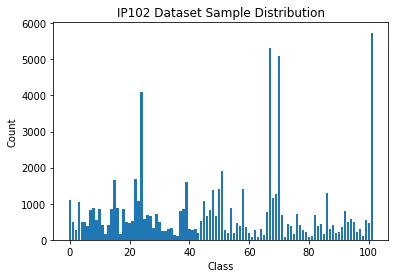

In [6]:
# plot histogram
# convert to ndarrays
total_counts = np.array(train_counts) + np.array(val_counts) + np.array(test_counts)

# train
plt.bar(classes, total_counts)
plt.title("IP102 Dataset Sample Distribution")
plt.xlabel('Class')
plt.ylabel('Count')

plt.show()

In [7]:
# order the train counts
mySort = sorted(zip(classes,train_counts), key=lambda x: x[1], reverse=True)
train_classes_ord = [cnum for cnum, count in mySort]
train_counts_ord = [count for cnum, count in mySort]
train_counts_cumsum = np.cumsum(train_counts_ord)

# choose top 'n' classes based on number of counts
n_desired_classes = 4
desired_classes = [str(i) for i in train_classes_ord[:n_desired_classes]]
display(desired_classes)

['101', '67', '70', '24']

# Load using `keras.preprocessing` 

See [tensorflow docs](https://www.tensorflow.org/tutorials/load_data/images#load_using_keraspreprocessing)

In [8]:
# choose desired image size
img_size = (224, 224)

# create ImageDataGenerators
datagen_train = keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
)

datagen_test = keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
)

datagen_val = keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
)

# load the data
generator_train = datagen_train.flow_from_directory(
    directory='./ip102/train/',
    target_size=img_size,
    color_mode="rgb",
    class_mode="categorical",
    classes=desired_classes,
    batch_size=32,
    shuffle=True
)

generator_test = datagen_test.flow_from_directory(
    directory='./ip102/test/',
    target_size=img_size,
    color_mode="rgb",
    class_mode="categorical",
    classes=desired_classes,
    batch_size=32,
    shuffle=True
)

generator_val = datagen_val.flow_from_directory(
    directory='./ip102/val/',
    target_size=img_size,
    color_mode="rgb",
    class_mode="categorical",
    classes=desired_classes,
    batch_size=32,
    shuffle=True
)

Found 12134 images belonging to 4 classes.
Found 6071 images belonging to 4 classes.
Found 2020 images belonging to 4 classes.


# AlexNet

In [0]:
# define AlexNet as keras sequential model
# ref: https://medium.com/datadriveninvestor/cnn-architecture-series-alexnet-with-implementation-part-ii-7f7afa2ac66a

n_classes = n_desired_classes

model = keras.models.Sequential([
    # conv layer 1
    Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding="valid", activation = "relu"),
    MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"),

    # conv layer 2
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same", activation = "relu"),
    MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"),

    # conv layer 3
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"),

    # conv layer 4
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"),
    
    # conv layer 5
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"),
    MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"),

    # dense layers
    Flatten(),
    Dense(units = 4096, activation = "relu"),
    Dense(4096, activation = "relu"),

    # output
    Dense(n_classes, activation = "softmax")
])

In [10]:
display(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)       8

None

In [0]:
# configure the learning process
model.compile(
    # define optimizer and set learning rate
    optimizer=keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True),

    # choose a loss function
    loss=keras.losses.CategoricalCrossentropy(),

    # choose a metric to report
    metrics=['accuracy']
)

In [12]:
# train model
num_train = train_counts_cumsum[n_desired_classes-1]
display(num_train)
BATCH_SIZE = 32

history = model.fit(
    generator_train,
    epochs=5,
    steps_per_epoch=np.ceil((num_train)/BATCH_SIZE),
    validation_data=generator_val,
    validation_steps=np.ceil(6071/32)
)

12134

Epoch 1/5
380/380 [==============================] - 114s 299ms/step - loss: 1.1922 - accuracy: 0.4604 - val_loss: 1.0376 - val_accuracy: 0.5631
Epoch 2/5
380/380 [==============================] - 112s 295ms/step - loss: 1.0298 - accuracy: 0.5698 - val_loss: 1.0291 - val_accuracy: 0.5629
Epoch 3/5
380/380 [==============================] - 111s 293ms/step - loss: 0.9569 - accuracy: 0.6118 - val_loss: 0.9247 - val_accuracy: 0.6309
Epoch 4/5
380/380 [==============================] - 113s 296ms/step - loss: 0.8998 - accuracy: 0.6397 - val_loss: 0.9315 - val_accuracy: 0.6264
Epoch 5/5
380/380 [==============================] - 113s 296ms/step - loss: 0.8421 - accuracy: 0.6661 - val_loss: 0.8773 - val_accuracy: 0.6568


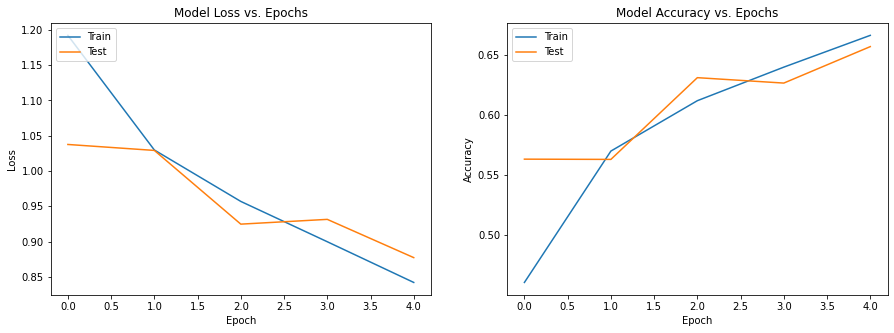

In [13]:
# visualize training
plt.figure(figsize=(15,5))

# plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss vs. Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# show plot
plt.show()

In [0]:
# function to reset model weights (use in between training runs)
def reset_weights(model):
  for layer in model.layers: 
    if isinstance(layer, tf.keras.Model):
      reset_weights(layer)
      continue
    for k, initializer in layer.__dict__.items():
      if "initializer" not in k:
        continue
      # find the corresponding variable
      var = getattr(layer, k.replace("_initializer", ""))
      var.assign(initializer(var.shape, var.dtype))

In [0]:
reset_weights(model)

In [0]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues, filename=None):
  if normalize:
    cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
  
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  #plt.savefig(filename)
  plt.show()

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# get predictions
y_pred_raw = model.predict_generator(generator_val, 6071 // BATCH_SIZE+1)
y_pred = np.argmax(y_pred_raw, axis=1)

# get actual classes
# y_test_inverted = [np.argmax(val) for val in y_test]

ValueError: ignored

In [27]:
display(np.unique(y_pred))

all_val_labels = []
for images, labels in generator_val:
  all_val_labels.append(labels)
  print(len(all_val_labels))
print(all_val_labels)

# generate confusion matrix
cm = confusion_matrix(all_val_labels, y_pred)

# get target names
target_names = ['0', '1', '2', '3']

# generate plot
plot_confusion_matrix(cm, target_names, normalize=False)

array([0, 1, 2, 3])

Streaming output truncated to the last 5000 lines.
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389

KeyboardInterrupt: ignored

In [0]:
### TRY TRAINING ON ALEXNET NOW ###

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pickle 

# import with pickle
filename = 'gdrive/My Drive/Colab Notebooks/BME 590: ML in Imaging/MosquitoNet/AlexNet/mosquito_dataset.pkl'
infile = open(filename,'rb')
dataset = pickle.load(infile)
infile.close()

In [29]:
# extract headlegs images from dictionary
x_full = [np.array(example["headlegs"]) for example in dataset]
x_full.extend([np.array(example["wings"]) for example in dataset])
x_full.extend([np.array(example["palps"]) for example in dataset])
y_full = [np.array(example["label"]) for example in dataset]
y_full.extend([np.array(example["label"]) for example in dataset])
y_full.extend([np.array(example["label"]) for example in dataset])

### one-hot encoding ###
# create one-hot label vectors
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_full)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_full_onehot = onehot_encoder.fit_transform(integer_encoded)

# # invert first example
# inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
# print(onehot_encoded[0, :])
# print(inverted)

# one-hot encoding with ONLY sklearn OneHotEncolder
# onehotencoder = OneHotEncoder()
# y_train_onehot = onehotencoder.fit_transform(y_train.reshape(-1,1)).toarray()
# y_test_onehot = onehotencoder.fit_transform(y_test.reshape(-1,1)).toarray()

### train-test splits ###
# create splits
from  sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full_onehot, test_size=0.2, shuffle=True, random_state=0)

# convert to numpy array
x_train = np.array([np.array(el) for el in x_train])
x_test = np.array([np.array(el) for el in x_test])
y_train = np.array([np.array(el) for el in y_train])
y_test = np.array([np.array(el) for el in y_test])

# print summary
print('x_full: ' + str(len(x_full)) + ' samples, type: ' + str(type(x_full)))
print('y_full: ' + str(len(y_full)) + ' samples, type: ' + str(type(y_full)))
print('x_train: ' + str(len(x_train)) + ' samples, shape: ' + str(x_train.shape))
print('y_train: ' + str(len(y_train)) + ' samples, shape: ' + str(y_train.shape))
print('x_test: ' + str(len(x_test)) + ' samples, shape: ' + str(x_test.shape))
print('y_test: ' + str(len(y_test)) + ' samples, shape: ' + str(y_test.shape))

x_full: 3981 samples, type: <class 'list'>
y_full: 3981 samples, type: <class 'list'>
x_train: 3184 samples, shape: (3184, 224, 224, 3)
y_train: 3184 samples, shape: (3184, 4)
x_test: 797 samples, shape: (797, 224, 224, 3)
y_test: 797 samples, shape: (797, 4)


In [0]:
# # resize images
# import cv2
# new_shape = (227,227)
# x_full_resized = np.empty(shape=(len(x_full), 227, 227, 3))
# for idx in range(0, len(x_full)):
#     x_full_resized[idx] = cv2.resize(x_full[idx], new_shape)

# preprocess dataset with keras
from tensorflow import keras

# create ImageDataGenerator instances for train & test
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=0.2,
    width_shift_range=0.2,
)
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=0.2,
    width_shift_range=0.2
)

# create generators
BATCH_SIZE = 32
train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(x_test, y_test, batch_size=BATCH_SIZE)

In [31]:
# train model
history_finetune = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=np.ceil((3184)/BATCH_SIZE),
    validation_data=test_generator,
    validation_steps=np.ceil(797/32)
)

Epoch 1/10
100/100 [==============================] - 45s 450ms/step - loss: 1.2727 - accuracy: 0.4375 - val_loss: 1.2696 - val_accuracy: 0.4479
Epoch 2/10
100/100 [==============================] - 44s 443ms/step - loss: 1.2644 - accuracy: 0.4447 - val_loss: 1.2637 - val_accuracy: 0.4529
Epoch 3/10
100/100 [==============================] - 44s 444ms/step - loss: 1.2642 - accuracy: 0.4447 - val_loss: 1.2625 - val_accuracy: 0.4567
Epoch 4/10
100/100 [==============================] - 44s 443ms/step - loss: 1.2618 - accuracy: 0.4447 - val_loss: 1.2532 - val_accuracy: 0.4517
Epoch 5/10
100/100 [==============================] - 44s 444ms/step - loss: 1.2596 - accuracy: 0.4447 - val_loss: 1.2699 - val_accuracy: 0.4517
Epoch 6/10
100/100 [==============================] - 44s 445ms/step - loss: 1.2605 - accuracy: 0.4447 - val_loss: 1.2778 - val_accuracy: 0.4341
Epoch 7/10
100/100 [==============================] - 45s 446ms/step - loss: 1.2587 - accuracy: 0.4447 - val_loss: 1.2528 - val_ac

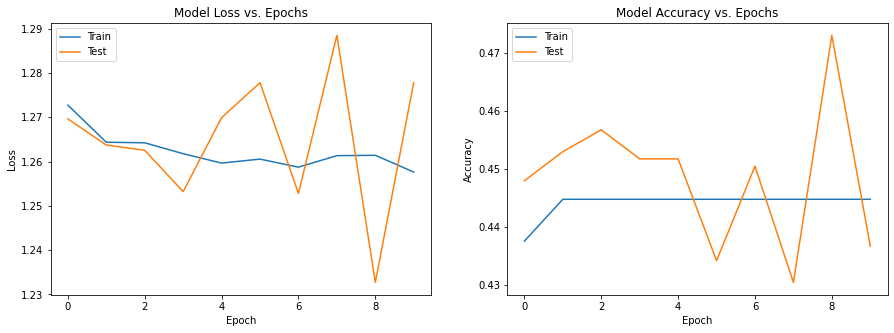

In [32]:
# visualize training
plt.figure(figsize=(15,5))

# plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['loss'])
plt.plot(history_finetune.history['val_loss'])
plt.title('Model Loss vs. Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['accuracy'])
plt.plot(history_finetune.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# show plot
plt.show()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

# get predictions
y_pred_raw = model.predict_generator(test_generator, len(x_test) // BATCH_SIZE+1)
y_pred = np.argmax(y_pred_raw, axis=1)

# get actual classes
y_test_inverted = [np.argmax(val) for val in y_test]

# generate confusion matrix
cm = confusion_matrix(y_test_inverted, y_pred)

# get target names
target_names = label_encoder.inverse_transform(np.arange(0,4))

# generate plot
plot_confusion_matrix(cm, target_names, normalize=False)